In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect,text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# inspect database structure
inspector = inspect(engine)


In [8]:
# View all of the classes that automap found
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Get column format of measurement table
columns = inspector.get_columns("measurement")

for column in columns:
    print(f"Column: {column['name']}, Type: {column['type']}")

Column: id, Type: INTEGER
Column: station, Type: TEXT
Column: date, Type: TEXT
Column: prcp, Type: FLOAT
Column: tobs, Type: FLOAT


In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date


('2017-08-23',)

2017-08-23 00:00:00
2016-08-23 00:00:00


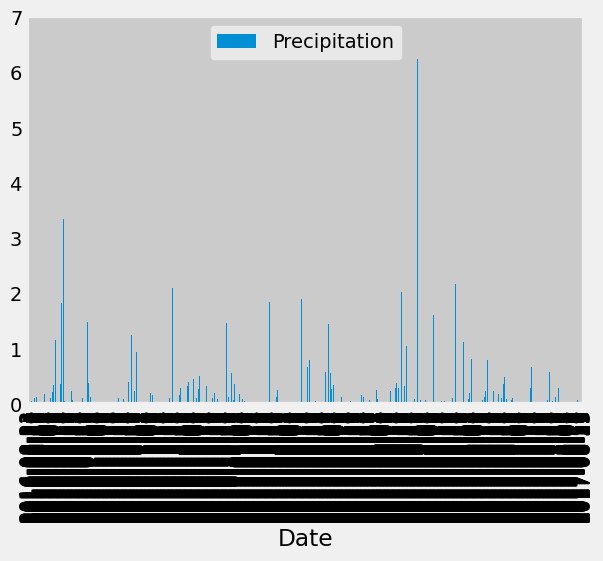

<Figure size 1000x500 with 0 Axes>

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Calculate the date one year from the last date in data set.
last_date = recent_date[0]
last_date = datetime.strptime(last_date, "%Y-%m-%d")
print(last_date)

first_date = last_date - relativedelta(years=1)
print(first_date)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date,measurement.prcp).\
    filter(measurement.date >= '2016-08-23')

comprehension = [{"Date": row[0],"Precipitation":row[1]} for row in query]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(comprehension, columns = ['Date', 'Precipitation'])


# Sort the dataframe by date
df = df.set_index('Date')
df = df.sort_index()
df = df.dropna()
df

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
describe = pd.DataFrame(df['Precipitation'].describe())
describe

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
query = session.query(station.station).distinct().count()
query

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

for row in query:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
summary = session.query(
    func.min(measurement.tobs).label("min"),
    func.max(measurement.tobs).label("max"),
    func.avg(measurement.tobs).label("avg")).\
    filter(measurement.station == 'USC00519281').first()


print(f"Min: {summary.min}, Max: {summary.max}, Avg: {summary.avg}")

Min: 54.0, Max: 85.0, Avg: 71.66378066378067


2017-08-18 00:00:00
2016-08-18 00:00:00


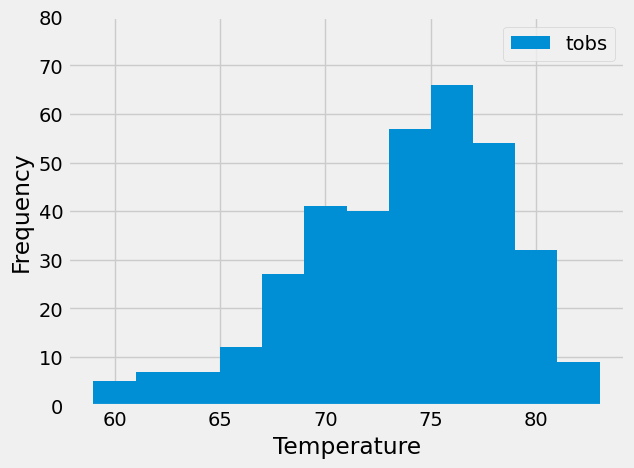

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(measurement.date).\
    filter(measurement.station == 'USC00519281').\
    order_by(measurement.date.desc()).first()

last_date = last_date[0]
last_date = datetime.strptime(last_date, "%Y-%m-%d")
print(last_date)

first_date = last_date - relativedelta(months=12)
print(first_date)

year_temp = session.query(measurement.date,measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= '2016-08-18').\
    filter(measurement.date <= '2017-08-18')

data = [(row.date, row.tobs) for row in year_temp]

df2 = pd.DataFrame(data, columns = ['date', 'tobs'])

df2['tobs'].plot.hist(bins=12)
plt.xlabel('Temperature')
plt.yticks(range(0, int(df2['tobs'].value_counts().max()) + 50, 10))
plt.legend()
plt.show()


# Close Session

In [19]:
# Close Session
session.close()